In [2]:
import numpy as np
import numpy.random as npr
import math
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import time
import sys
import os.path

# estimating EQA using SPAs

## collecting data

In [21]:
# inverse cdf of 1 - 1/x
def ppf(y):
    return 1/(1-y)
ppf = np.vectorize(ppf)

bmps = [2] + [i for i in range(20,201,20)]
items = 2
trials = 10_000_000

revs_separate = []
revs_bundle = []

for bmp in bmps:
    revs_separate_temp = []
    revs_bundle_temp = []

    for i in tqdm(range(trials)):
        valuations = ppf(npr.random((bmp, items)))
        
        rev = np.sum(np.sort(valuations, 0)[-2,:])
        revs_separate_temp.append(rev)

        rev = np.sort(np.sum(valuations, 1), 0)[-2]
        revs_bundle_temp.append(rev)

    revs_separate.append(pd.Series(revs_separate_temp))
    revs_bundle.append(pd.Series(revs_bundle_temp))

[x.mean() - 2*n for x, n in zip(revs_bundle, bmps)]


rev_vals = np.array(bmps)
rev_cols = [f'rev_{x}' for x in rev_vals]

sep_df = pd.DataFrame(dict(zip(rev_cols, revs_separate)))
bun_df = pd.DataFrame(dict(zip(rev_cols, revs_bundle)))

sep_revs = sep_df.mean()
bun_revs = bun_df.mean()

sep_revs.name = 'rev_spa_separate'
bun_revs.name = 'rev_spa_bundle'

sep_conf = sep_df.apply(lambda a: st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
bun_conf = bun_df.apply(lambda a: st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))

sep_conf = sep_conf.T
bun_conf = bun_conf.T
sep_conf.columns = ['0.95_conf_low_separate', '0.95_conf_high_separate']
bun_conf.columns = ['0.95_conf_low_bundle', '0.95_conf_high_bundle']

spa_data = pd.concat([sep_revs, bun_revs, sep_conf, bun_conf], axis=1).T


path = '../data/manual-SPAs/'
spa_data.to_csv(path + f'SPA_EQA_{trials}_trials.csv')

 26%|██▌       | 2611074/10000000 [04:47<19:21, 6362.58it/s] 

## graphing

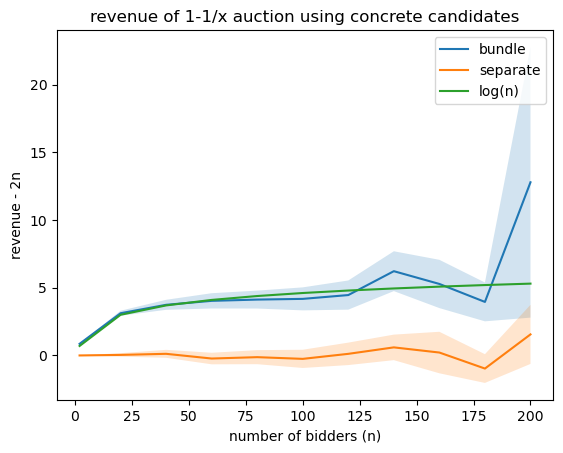

In [20]:
bmps = np.array(bmps)

temp = bun_conf.T - 2*bmps
plt.fill_between(bmps, temp.T.iloc[:,0], temp.T.iloc[:,1], alpha=0.2)
plt.plot(bmps, bun_revs - 2*bmps, label='bundle')

temp = sep_conf.T - 2*bmps
plt.fill_between(bmps, temp.T.iloc[:,0], temp.T.iloc[:,1], alpha=0.2)
plt.plot(bmps, sep_revs - 2*bmps, label='separate')

plt.plot(bmps, 1*np.log(bmps), label='log(n)')

plt.xlabel('number of bidders (n)')
plt.ylabel('revenue - 2n')
plt.title('revenue of 1-1/x auction using concrete candidates')

plt.legend()
plt.show()

## replicating DL using SPAs

bidder x item combos:

1 x 2 - can't do this one

1 x 10 - can't do this one

2 x 2

3 x 10

5 x 10

In [217]:
# npr.seed(100)
# a = Distribution('1-1/x', 1, np.inf, '1/(1-y)')

# inverse cdf of 1 - 1/x
def ppf(y):
    return y
ppf = np.vectorize(ppf)

bidder_mults = [2, 3, 5]
item_mults   = [2, 10, 10]
trials = 1_000_000

revs_separate = []
revs_bundle = []

for bidders, items in zip(bidder_mults, item_mults):
    revs_separate_temp = []
    revs_bundle_temp = []

    for i in tqdm(range(trials)):
        valuations = ppf(npr.random((bidders, items)))
        
        rev = np.sum(np.sort(valuations, 0)[-2,:])
        revs_separate_temp.append(rev)

        rev = np.sort(np.sum(valuations, 1), 0)[-2]
        revs_bundle_temp.append(rev)

    revs_separate.append(pd.Series(revs_separate_temp))
    revs_bundle.append(pd.Series(revs_bundle_temp))

cols = ['2x2', '3x10', '5x10']
df_separate_dl = pd.DataFrame(dict(zip(cols, revs_separate)))
df_bundle_dl = pd.DataFrame(dict(zip(cols, revs_bundle)))

100%|██████████| 1000000/1000000 [00:35<00:00, 28548.12it/s]


In [218]:
df_separate_dl.mean(), df_bundle_dl.mean()

(2x2     0.666268
 3x10    4.998278
 5x10    6.667753
 dtype: float64,
 2x2     0.766070
 3x10    4.998873
 5x10    5.456683
 dtype: float64)